# Sports League Optimization Analysis

This notebook analyzes the performance of different optimization algorithms for the Sports League problem, where we need to assign players to teams in a balanced way while respecting position and budget constraints.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import functools
import multiprocessing as mp
from copy import deepcopy
import sys
import pickle

from solution import LeagueSolution, LeagueHillClimbingSolution, LeagueSASolution
from evolution import (
    hill_climbing, 
    simulated_annealing, 
    genetic_algorithm,
    # Selection operators
    selection_tournament,
    selection_ranking,
    selection_tournament_variable_k,
    selection_boltzmann,
    # Crossover operators
    crossover_one_point,
    crossover_one_point_prefer_valid,
    crossover_uniform,
    crossover_uniform_prefer_valid,
    # Mutation operators
    mutate_swap,
    mutate_swap_constrained,
    mutate_team_shift,
    mutate_targeted_player_exchange,
    mutate_shuffle_within_team_constrained
)

# Set up plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## 1. Data Loading and Preparation

In [2]:
# Load player data
players_df = pd.read_csv("players.csv", sep=";")

# Normalize column names if needed
if "Salary (€M)" in players_df.columns and "Salary" not in players_df.columns:
    # Create a copy of the Salary column with the simpler name
    players_df["Salary"] = players_df["Salary (€M)"]
    print("Normalized 'Salary (€M)' column to 'Salary'")

# Convert to dictionary format
players_data = players_df.to_dict(orient="records")

# Display the first few players
players_df.head()

Normalized 'Salary (€M)' column to 'Salary'


,Unnamed: 0,Name,Position,Skill,Salary (€M),Salary
0,0,Alex Carter,GK,85,90,90
1,1,Jordan Smith,GK,88,100,100
2,2,Ryan Mitchell,GK,83,85,85
3,3,Chris Thompson,GK,80,80,80
4,4,Blake Henderson,GK,87,95,95


## 2. Experiment Setup

### 2.1 Algorithm Configurations

In [3]:
# Define algorithm configurations for comparison
configs = {
    "Hill Climbing": {
        "algorithm": "Hill Climbing",
        "params": {
            "max_iterations": 500,
            "max_no_improvement": 100,
            "verbose": False
        }
    },
    "Simulated Annealing": {
        "algorithm": "Simulated Annealing",
        "params": {
            "initial_temperature": 200.0,
            "cooling_rate": 0.95,
            "min_temperature": 1e-5,
            "iterations_per_temp": 20,
            "verbose": False
        }
    },
    "Genetic Algorithm (Tournament)": {
        "algorithm": "Genetic Algorithm",
        "params": {
            "population_size": 100,
            "max_generations": 50,
            "selection_operator": selection_tournament_variable_k,
            "selection_params": {"k": 3},
            "crossover_operator": crossover_one_point_prefer_valid,
            "crossover_rate": 0.8,
            "mutation_operator": mutate_targeted_player_exchange,
            "mutation_rate": 0.1,
            "elitism": True,
            "elitism_size": 2,
            "verbose": False
        }
    },
    "Genetic Algorithm (Ranking)": {
        "algorithm": "Genetic Algorithm",
        "params": {
            "population_size": 100,
            "max_generations": 50,
            "selection_operator": selection_ranking,
            "selection_params": {},
            "crossover_operator": crossover_one_point_prefer_valid,
            "crossover_rate": 0.8,
            "mutation_operator": mutate_targeted_player_exchange,
            "mutation_rate": 0.1,
            "elitism": True,
            "elitism_size": 2,
            "verbose": False
        }
    },
    "Hybrid GA": {
        "algorithm": "Hybrid GA",
        "params": {
            "population_size": 75,
            "max_generations": 40,
            "selection_operator": selection_tournament_variable_k,
            "selection_params": {"k": 3},
            "crossover_operator": crossover_uniform_prefer_valid,
            "crossover_rate": 0.85,
            "mutation_operator": mutate_targeted_player_exchange,
            "mutation_rate": 0.15,
            "elitism": True,
            "elitism_size": 1,
            "local_search": {
                "algorithm": "hill_climbing",
                "frequency": 5,  # Apply HC every 5 generations
                "iterations": 50  # HC iterations per application
            },
            "verbose": False
        }
    }
}

# Add promising algorithm configurations
promising_configs = {
    "Optimized Hybrid GA": {
        "algorithm": "Hybrid GA",
        "params": {
            "population_size": 100,
            "max_generations": 50,
            "selection_operator": selection_tournament_variable_k,
            "selection_params": {"k": 5},  # Increased tournament size
            "crossover_operator": crossover_uniform_prefer_valid,
            "crossover_rate": 0.9,  # Increased crossover rate
            "mutation_operator": mutate_targeted_player_exchange,
            "mutation_rate": 0.2,  # Increased mutation rate
            "elitism": True,
            "elitism_size": 3,  # Increased elitism
            "local_search": {
                "algorithm": "hill_climbing",
                "frequency": 3,  # More frequent local search
                "iterations": 75  # More iterations per local search
            },
            "verbose": False
        }
    },
    "Enhanced Simulated Annealing": {
        "algorithm": "Simulated Annealing",
        "params": {
            "initial_temperature": 300.0,  # Higher initial temperature
            "cooling_rate": 0.97,  # Slower cooling
            "min_temperature": 1e-6,  # Lower final temperature
            "iterations_per_temp": 30,  # More iterations per temperature
            "verbose": False
        }
    },
    "Intensive Hill Climbing": {
        "algorithm": "Hill Climbing",
        "params": {
            "max_iterations": 1000,  # More iterations
            "max_no_improvement": 200,  # More patience
            "verbose": False
        }
    }
}

# Merge standard and promising configurations
all_configs = {**configs, **promising_configs}

### 2.2 Fitness Evaluation Counter

We'll create a utility to count the number of fitness evaluations for fair comparison:

In [4]:
class FitnessCounter:
    """
    A utility class to count the number of fitness evaluations.
    
    This class temporarily replaces the fitness method of LeagueSolution with a wrapper
    that increments a counter each time the fitness method is called. This allows us to
    accurately measure the number of fitness evaluations performed by each algorithm.
    
    Attributes:
        original_fitness: The original fitness method of LeagueSolution
        count: The number of fitness evaluations counted
    """
    def __init__(self):
        self.original_fitness = LeagueSolution.fitness
        self.count = 0
    
    def start_counting(self):
        """
        Start counting fitness evaluations by replacing the fitness method with a wrapper.
        """
        self.original_fitness = LeagueSolution.fitness
        self.count = 0
        
        # Use functools.partial to create a bound method that correctly handles 'self'
        def counting_wrapper(instance):
            self.count += 1
            return self.original_fitness(instance)
        
        # Replace the fitness method with our wrapper
        LeagueSolution.fitness = counting_wrapper
        
    def stop_counting(self):
        """
        Stop counting fitness evaluations and restore the original fitness method.
        
        Returns:
            int: The number of fitness evaluations counted
        """
        # Restore the original fitness method
        LeagueSolution.fitness = self.original_fitness
        return self.count

# Initialize the counter
fitness_counter = FitnessCounter()

### 2.3 Experiment Configuration

In [5]:
# Experiment configuration
EXPERIMENT_CONFIG = {
    'parallel': True,           # Whether to run experiments in parallel
    'num_runs': 30,              # Number of runs per configuration
    'num_processes': None,      # Number of parallel processes (None = auto)
    'max_evaluations': None,    # Maximum number of fitness evaluations (None = unlimited)
    'save_results': True,       # Whether to save results to file
    'results_file': 'experiment_results.csv',  # File to save results
    'verbose': True,            # Whether to print detailed progress
    'save_best_solution': True, # Whether to save the best solution found
    'max_exp_value': 700,       # Maximum value for exponential calculations to prevent overflow
    'pickle_solutions': False   # Whether to pickle solutions (can cause recursion errors)
}

### 2.4 Safe Exponential Function

To prevent numeric overflow in exponential calculations, we'll define a safe exponential function:

In [6]:
def safe_exp(x, max_value=EXPERIMENT_CONFIG['max_exp_value']):
    """
    Safely compute exponential function without overflow.
    
    This function prevents numeric overflow by clipping the input value to a safe range
    before computing the exponential. This is particularly important for operations like
    Simulated Annealing's acceptance probability or Boltzmann selection in genetic algorithms.
    
    Args:
        x: Input value
        max_value: Maximum value to clip input (default: 700, which is close to np.log(sys.float_info.max))
        
    Returns:
        float: exp(x) computed safely without risk of overflow
    """
    return np.exp(np.clip(x, -max_value, max_value))

# Monkey patch numpy's exp function to use our safe version
original_exp = np.exp
np.exp = safe_exp

### 2.5 Solution Serialization Helper

To prevent recursion errors when passing solutions between processes, we'll create helper functions
to extract only the necessary data from solution objects:

In [7]:
def extract_solution_data(solution):
    """
    Extract only the necessary data from a solution object to prevent recursion errors.
    
    This function creates a simplified representation of a solution object that can be
    safely passed between processes without causing recursion errors during comparison
    or serialization.
    
    Args:
        solution: A LeagueSolution object or subclass
        
    Returns:
        dict: A dictionary containing only the essential data from the solution
    """
    if solution is None:
        return None
    
    # Extract only the necessary data
    solution_data = {
        'repr': solution.repr.copy() if hasattr(solution, 'repr') else None,
        'fitness_value': solution.fitness(),
        'num_teams': solution.num_teams if hasattr(solution, 'num_teams') else None,
        'team_size': solution.team_size if hasattr(solution, 'team_size') else None,
        'solution_type': solution.__class__.__name__
    }
    
    return solution_data

def recreate_solution_for_display(solution_data, players_list):
    """
    Recreate a solution object from extracted data for display purposes.
    
    This function is used to recreate a solution object from the simplified data
    representation for visualization and analysis after all parallel processing is complete.
    
    Args:
        solution_data: Dictionary containing solution data
        players_list: List of player dictionaries
        
    Returns:
        LeagueSolution: A recreated solution object
    """
    if solution_data is None:
        return None
    
    # Create a new solution object
    solution_type = solution_data.get('solution_type', 'LeagueSolution')
    
    if solution_type == 'LeagueHillClimbingSolution':
        solution = LeagueHillClimbingSolution(players=players_list)
    elif solution_type == 'LeagueSASolution':
        solution = LeagueSASolution(players=players_list)
    else:
        solution = LeagueSolution(players=players_list)
    
    # Set the representation
    if solution_data.get('repr') is not None:
        solution.repr = solution_data['repr']
    
    return solution

### 2.6 Experiment Runner Functions

In [8]:
# Function to run a single experiment
def run_experiment(config, config_name, players_list, run_id, max_evaluations=None):
    """
    Run a single experiment with the specified configuration.
    
    This function executes a single run of an optimization algorithm with the given
    configuration and returns the results, including performance metrics and the
    solution found.
    
    Args:
        config (dict): Algorithm configuration
        config_name (str): Name of the configuration
        players_list (list): List of player dictionaries
        run_id (int): Run identifier
        max_evaluations (int, optional): Maximum number of fitness evaluations
        
    Returns:
        dict: Results of the experiment, including:
            - Configuration: Name of the configuration
            - Algorithm: Type of algorithm used
            - Run: Run number
            - Best Fitness: Fitness value of the best solution found
            - Iterations: Number of iterations/generations
            - Function Evaluations: Number of fitness evaluations
            - Runtime (s): Execution time in seconds
            - History: List of fitness values over iterations
            - Solution Data: Simplified representation of the best solution
    """
    # Reset random seed for reproducibility
    random.seed(42 + run_id)
    np.random.seed(42 + run_id)
    
    # Create a new fitness counter for this process
    local_counter = FitnessCounter()
    local_counter.start_counting()
    
    # Record start time
    start_time = time.time()
    
    # Run the appropriate algorithm
    if config['algorithm'] == 'Hill Climbing':
        # Create initial solution
        initial_solution = LeagueHillClimbingSolution(players=players_list)
        
        # Run Hill Climbing
        best_solution, best_fitness, history = hill_climbing(
            initial_solution,
            **config['params']
        )
        
        iterations = len(history)
        
    elif config['algorithm'] == 'Simulated Annealing':
        # Create initial solution
        initial_solution = LeagueSASolution(players=players_list)
        
        # Run Simulated Annealing
        best_solution, best_fitness, history = simulated_annealing(
            initial_solution,
            **config['params']
        )
        
        iterations = len(history)
        
    elif config['algorithm'] in ['Genetic Algorithm', 'Hybrid GA']:
        # Run Genetic Algorithm
        best_solution, best_fitness, history = genetic_algorithm(
            players_list,
            **config['params']
        )
        
        iterations = len(history)
    
    # Record end time and calculate runtime
    runtime = time.time() - start_time
    
    # Get number of fitness evaluations
    evaluations = local_counter.stop_counting()
    
    # Ensure best_fitness is a valid number (not inf or NaN)
    if best_fitness is None or np.isinf(best_fitness) or np.isnan(best_fitness):
        # Calculate fitness directly from the best solution
        best_fitness = best_solution.fitness()
    
    # Extract only the necessary data from the solution to prevent recursion errors
    solution_data = extract_solution_data(best_solution)
    
    # Return results
    return {
        'Configuration': config_name,
        'Algorithm': config['algorithm'],
        'Run': run_id + 1,
        'Best Fitness': best_fitness,
        'Iterations': iterations,
        'Function Evaluations': evaluations,
        'Runtime (s)': runtime,
        'History': history,
        'Solution Data': solution_data  # Simplified representation instead of full solution object
    }

# Function to run multiple experiments sequentially
def run_multiple_experiments(configs, players_list, num_runs=5, max_evaluations=None):
    """
    Run multiple experiments sequentially.
    
    This function executes multiple runs of each algorithm configuration sequentially
    and collects the results.
    
    Args:
        configs (dict): Dictionary of algorithm configurations
        players_list (list): List of player dictionaries
        num_runs (int): Number of runs per configuration
        max_evaluations (int, optional): Maximum number of fitness evaluations
        
    Returns:
        tuple: (results_df, history_data, best_solutions)
            - results_df: DataFrame with results of all experiments
            - history_data: Dictionary with convergence history for each configuration and run
            - best_solutions: Dictionary with the best solution found for each configuration
    """
    results = []
    history_data = {config_name: {} for config_name in configs.keys()}
    best_solutions = {}
    
    for config_name, config in configs.items():
        print(f"Running {config_name}...")
        
        for run in range(num_runs):
            if EXPERIMENT_CONFIG['verbose']:
                print(f"  Run {run+1}/{num_runs}...")
                
            result = run_experiment(
                config=config,
                config_name=config_name,
                players_list=players_list,
                run_id=run,
                max_evaluations=max_evaluations
            )
            
            # Extract values from result
            best_fitness = result['Best Fitness']
            iterations = result['Iterations']
            evaluations = result['Function Evaluations']
            runtime = result['Runtime (s)']
            history = result['History']
            solution_data = result['Solution Data']
            
            results.append({
                'Configuration': config_name,
                'Algorithm': config['algorithm'],
                'Run': run + 1,
                'Best Fitness': best_fitness,
                'Iterations': iterations,
                'Function Evaluations': evaluations,
                'Runtime (s)': runtime
            })
            
            history_data[config_name][run] = history
            
            # Store best solution if it's better than previous best for this config
            if config_name not in best_solutions or best_fitness < best_solutions[config_name]['fitness']:
                best_solutions[config_name] = {
                    'solution_data': solution_data,
                    'fitness': best_fitness,
                    'run': run + 1
                }
            
            if EXPERIMENT_CONFIG['verbose']:
                print(f"    Fitness = {best_fitness:.6f}, Evaluations = {evaluations}, Runtime = {runtime:.2f}s")
    
    return pd.DataFrame(results), history_data, best_solutions

# Function to run a worker process for parallel execution
def run_worker(args):
    """
    Worker function for parallel execution.
    
    This function is executed by each worker process in parallel execution. It runs
    a single experiment and returns the results in a format that can be safely passed
    between processes.
    
    Args:
        args (tuple): (config, config_name, players_list, run_id, max_evaluations)
        
    Returns:
        tuple: (result_dict, (config_name, run_id, history, solution_data))
    """
    config, config_name, players_list, run_id, max_evaluations = args
    
    # Print start message to verify parallel execution
    print(f"\nProcess started for {config_name}, Run {run_id+1}")
    
    try:
        result = run_experiment(
            config=config,
            config_name=config_name,
            players_list=players_list,
            run_id=run_id,
            max_evaluations=max_evaluations
        )
        
        # Extract history and solution data for separate return
        history = result.pop('History')
        solution_data = result.pop('Solution Data')
        
        # Print completion message
        print(f"\nProcess completed for {config_name}, Run {run_id+1}")
        
        return result, (config_name, run_id, history, solution_data)
    
    except Exception as e:
        import traceback
        error_msg = f"Error in {config_name}, Run {run_id+1}: {str(e)}\n{traceback.format_exc()}"
        print(f"\n{error_msg}")
        return {"error": error_msg}, (config_name, run_id, [], None)

# Function to run experiments in parallel - completely refactored for true parallelism
def run_parallel_experiments(configs, players_list, num_runs=5, max_evaluations=None, num_processes=None):
    """
    Run multiple experiments in parallel using multiprocessing.
    
    This function executes multiple runs of each algorithm configuration in parallel
    using multiple processes and collects the results.
    
    Args:
        configs (dict): Dictionary of algorithm configurations
        players_list (list): List of player dictionaries
        num_runs (int): Number of runs per configuration
        max_evaluations (int, optional): Maximum number of fitness evaluations
        num_processes (int, optional): Number of processes to use. If None, uses CPU count.
        
    Returns:
        tuple: (results_df, history_data, best_solutions)
            - results_df: DataFrame with results of all experiments
            - history_data: Dictionary with convergence history for each configuration and run
            - best_solutions: Dictionary with the best solution found for each configuration
    """
    if num_processes is None:
        num_processes = mp.cpu_count()
    
    print(f"Running experiments in parallel with {num_processes} processes...")
    
    # Prepare arguments for all experiments
    all_args = []
    for config_name, config in configs.items():
        for run in range(num_runs):
            all_args.append((config, config_name, players_list, run, max_evaluations))
    
    # Initialize results containers
    results = []
    history_data = {config_name: {} for config_name in configs.keys()}
    best_solutions = {}
    
    # Use Process directly instead of Pool for better control
    processes = []
    result_queue = mp.Queue()
    
    def worker_wrapper(args, queue):
        """Wrapper function to put results in queue"""
        try:
            result = run_worker(args)
            queue.put(result)
        except Exception as e:
            import traceback
            error_msg = f"Error in worker process: {str(e)}\n{traceback.format_exc()}"
            queue.put(("ERROR", error_msg))
    
    # Start processes
    for i, args in enumerate(all_args):
        p = mp.Process(target=worker_wrapper, args=(args, result_queue))
        processes.append(p)
        p.start()
        
        # Limit number of concurrent processes
        if len(processes) >= num_processes:
            # Wait for a process to finish before starting more
            while not result_queue.empty():
                result_item = result_queue.get()
                if isinstance(result_item, tuple) and result_item[0] == "ERROR":
                    print(f"\nError in worker process: {result_item[1]}")
                else:
                    result, history_info = result_item
                    
                    # Skip if there was an error
                    if "error" in result:
                        print(f"\n{result['error']}")
                        continue
                    
                    results.append(result)
                    config_name, run_id, history, solution_data = history_info
                    history_data[config_name][run_id] = history
                    
                    # Store best solution if it's better than previous best for this config
                    if config_name not in best_solutions or result['Best Fitness'] < best_solutions[config_name]['fitness']:
                        best_solutions[config_name] = {
                            'solution_data': solution_data,
                            'fitness': result['Best Fitness'],
                            'run': run_id + 1
                        }
                    
                    if EXPERIMENT_CONFIG['verbose']:
                        print(f"\nCollected result: {config_name}, Run {run_id+1}")
            
            # Check if any processes have finished
            for p in processes[:]:
                if not p.is_alive():
                    p.join()
                    processes.remove(p)
    
    # Wait for remaining processes to finish
    while processes:
        for p in processes[:]:
            if not p.is_alive():
                p.join()
                processes.remove(p)
        
        # Collect results
        while not result_queue.empty():
            result_item = result_queue.get()
            if isinstance(result_item, tuple) and result_item[0] == "ERROR":
                print(f"\nError in worker process: {result_item[1]}")
            else:
                result, history_info = result_item
                
                # Skip if there was an error
                if "error" in result:
                    print(f"\n{result['error']}")
                    continue
                
                results.append(result)
                config_name, run_id, history, solution_data = history_info
                history_data[config_name][run_id] = history
                
                # Store best solution if it's better than previous best for this config
                if config_name not in best_solutions or result['Best Fitness'] < best_solutions[config_name]['fitness']:
                    best_solutions[config_name] = {
                        'solution_data': solution_data,
                        'fitness': result['Best Fitness'],
                        'run': run_id + 1
                    }
                
                if EXPERIMENT_CONFIG['verbose']:
                    print(f"\nCollected result: {config_name}, Run {run_id+1}")
        
        # Small sleep to prevent CPU hogging
        if processes:
            time.sleep(0.1)
    
    # Collect any remaining results
    while not result_queue.empty():
        result_item = result_queue.get()
        if isinstance(result_item, tuple) and result_item[0] == "ERROR":
            print(f"\nError in worker process: {result_item[1]}")
        else:
            result, history_info = result_item
            
            # Skip if there was an error
            if "error" in result:
                print(f"\n{result['error']}")
                continue
            
            results.append(result)
            config_name, run_id, history, solution_data = history_info
            history_data[config_name][run_id] = history
            
            # Store best solution if it's better than previous best for this config
            if config_name not in best_solutions or result['Best Fitness'] < best_solutions[config_name]['fitness']:
                best_solutions[config_name] = {
                    'solution_data': solution_data,
                    'fitness': result['Best Fitness'],
                    'run': run_id + 1
                }
            
            if EXPERIMENT_CONFIG['verbose']:
                print(f"\nCollected result: {config_name}, Run {run_id+1}")
    
    return pd.DataFrame(results), history_data, best_solutions

# Main function to run experiments (either sequential or parallel)
def run_experiments(configs, players_data, num_runs=5, parallel=False, num_processes=None, max_evaluations=None):
    """
    Run experiments either sequentially or in parallel.
    
    This function is the main entry point for running experiments. It decides whether
    to run experiments sequentially or in parallel based on the configuration.
    
    Args:
        configs (dict): Dictionary of algorithm configurations
        players_data (list): List of player dictionaries
        num_runs (int): Number of runs per configuration
        parallel (bool): Whether to run in parallel
        num_processes (int, optional): Number of processes to use for parallel execution
        max_evaluations (int, optional): Maximum number of fitness evaluations
        
    Returns:
        tuple: (results_df, history_data, best_solutions)
            - results_df: DataFrame with results of all experiments
            - history_data: Dictionary with convergence history for each configuration and run
            - best_solutions: Dictionary with the best solution found for each configuration
    """
    if parallel:
        results_df, history_data, best_solutions = run_parallel_experiments(
            configs, 
            players_data, 
            num_runs=num_runs, 
            max_evaluations=max_evaluations,
            num_processes=num_processes
        )
    else:
        results_df, history_data, best_solutions = run_multiple_experiments(
            configs, 
            players_data, 
            num_runs=num_runs, 
            max_evaluations=max_evaluations
        )
    
    return results_df, history_data, best_solutions

## 3. Algorithm Implementations

### 3.1 Hill Climbing

Hill Climbing is a local search algorithm that starts with an initial solution and iteratively moves to better neighboring solutions until no improvement is possible.

**Key Components:**
- **Neighborhood Generation**: Defined in `LeagueHillClimbingSolution.get_neighbors()`, which generates valid neighboring solutions by swapping players between teams.
- **Selection Strategy**: We use steepest ascent, selecting the best neighbor at each iteration.
- **Termination Criteria**: The algorithm stops when no better neighbor is found or after a maximum number of iterations.

### 3.2 Simulated Annealing

Simulated Annealing is inspired by the annealing process in metallurgy. It allows accepting worse solutions with a probability that decreases over time, helping to escape local optima.

**Key Components:**
- **Random Neighbor Generation**: Defined in `LeagueSASolution.get_random_neighbor()`, which generates a random valid neighboring solution.
- **Acceptance Probability**: Based on the temperature and the fitness difference between the current and new solutions.
- **Cooling Schedule**: The temperature decreases over time, reducing the probability of accepting worse solutions.

### 3.3 Genetic Algorithm

Genetic Algorithm is a population-based search algorithm inspired by natural selection and genetics.

**Key Components:**
- **Selection Operators**: We've implemented three selection mechanisms:
  - Tournament Selection: Selects the best solution from k random candidates.
  - Ranking Selection: Selects solutions with probability proportional to their rank.
  - Boltzmann Selection: Uses Boltzmann distribution to select solutions.

- **Crossover Operators**: We've implemented three crossover operators:
  - One-Point Crossover: Creates a child by taking a portion from each parent.
  - One-Point Prefer Valid: Tries multiple cut points to find a valid solution.
  - Uniform Crossover: Creates a child by randomly selecting genes from either parent.

- **Mutation Operators**: We've implemented four mutation operators:
  - Swap: Randomly swaps two players between teams.
  - Swap Constrained: Swaps players of the same position.
  - Team Shift: Shifts all player assignments by a random number.
  - Targeted Player Exchange: Swaps players between teams to improve balance.
  - Shuffle Within Team: Shuffles players within a team with other teams.

- **Elitism**: Preserves the best solutions from one generation to the next.

### 3.4 Hybrid Approach

We've also implemented a hybrid approach that combines Genetic Algorithm with Hill Climbing, applying local search to the best solutions periodically.

### 3.5 Promising Algorithm Configurations

Based on preliminary results, we've identified several promising algorithm configurations:

1. **Optimized Hybrid GA**: Enhanced version of the Hybrid GA with larger population, more aggressive mutation, and more frequent local search.

2. **Enhanced Simulated Annealing**: Version with higher initial temperature, slower cooling, and more iterations per temperature.

3. **Intensive Hill Climbing**: Version with more iterations and greater patience for finding improvements.

## 4. Performance Comparison

### 4.1 Experiment Configuration

We can run our experiments either sequentially or in parallel. Parallel execution significantly reduces the total runtime by distributing the workload across multiple CPU cores.

The experiment configuration is controlled by the `EXPERIMENT_CONFIG` dictionary:

- `parallel`: Set to `True` to enable parallel execution, `False` for sequential
- `num_runs`: Number of runs per algorithm configuration
- `num_processes`: Number of parallel processes (set to `None` to use all available CPU cores)
- `max_evaluations`: Maximum number of fitness evaluations per run (set to `None` for unlimited)
- `save_results`: Whether to save results to a CSV file
- `results_file`: Path to save the results CSV file
- `verbose`: Whether to print detailed progress information
- `save_best_solution`: Whether to save the best solution found
- `max_exp_value`: Maximum value for exponential calculations to prevent overflow
- `pickle_solutions`: Whether to pickle solutions (can cause recursion errors)

Let's run the experiments and compare the performance of different algorithms:

Running experiments in parallel with 32 processes...
Running experiments in parallel with 32 processes...

Process started for Hill Climbing, Run 1

Process started for Hill Climbing, Run 2
Process completed for Hill Climbing, Run 1


Process started for Hill Climbing, Run 3
Process completed for Hill Climbing, Run 2


Process started for Hill Climbing, Run 4
Process completed for Hill Climbing, Run 3


Process started for Hill Climbing, Run 5
Process completed for Hill Climbing, Run 4


Process started for Hill Climbing, Run 6
Process completed for Hill Climbing, Run 5


Process completed for Hill Climbing, Run 6
Process started for Hill Climbing, Run 7




Process started for Hill Climbing, Run 8
Process completed for Hill Climbing, Run 7
Process started for Hill Climbing, Run 9
Process completed for Hill Climbing, Run 8


Process started for Hill Climbing, Run 10
Process completed for Hill Climbing, Run 9


Process started for Hill Climbing, Run 11
Process completed for Hill Climbin

/tmp/ipykernel_79032/2836495178.py:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_stats = metric_stats.applymap(lambda x: f"{x:.6f}" if not pd.isna(x) and not np.isinf(x) else "N/A")


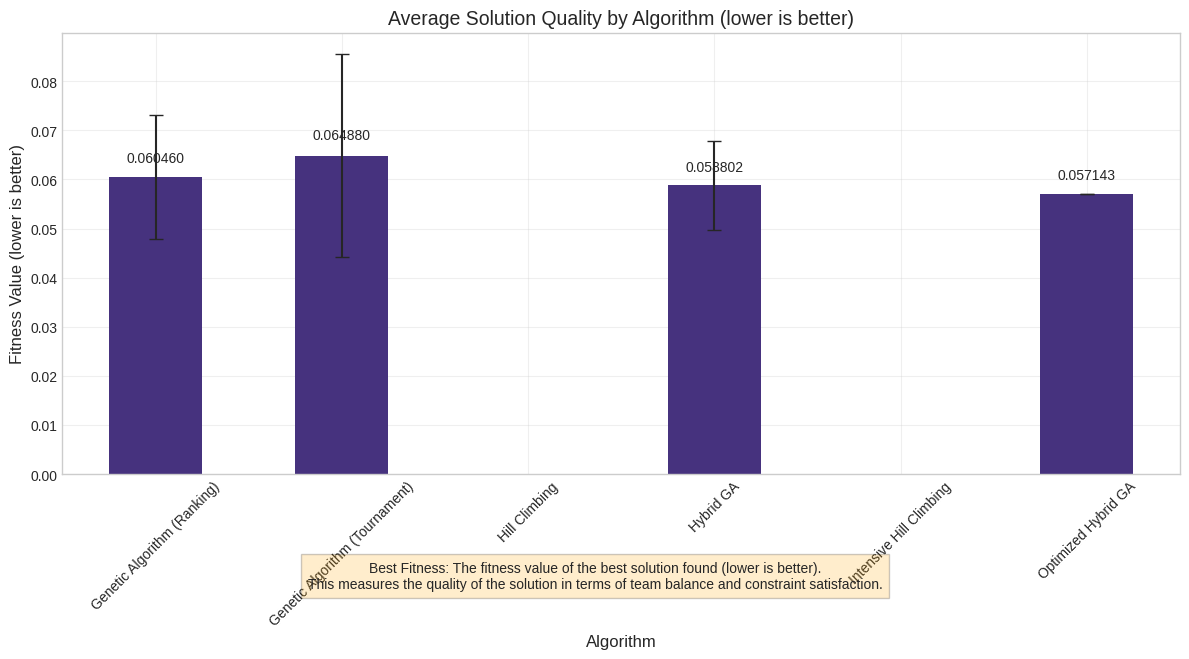


Iterations Statistics:
                                mean  std   min   max
Configuration                                        
Genetic Algorithm (Ranking)     51.0  0.0  51.0  51.0
Genetic Algorithm (Tournament)  51.0  0.0  51.0  51.0
Hill Climbing                    1.0  0.0   1.0   1.0
Hybrid GA                       41.0  0.0  41.0  41.0
Intensive Hill Climbing          1.0  0.0   1.0   1.0
Optimized Hybrid GA             51.0  0.0  51.0  51.0


/tmp/ipykernel_79032/2836495178.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_stats = metric_stats.applymap(lambda x: f"{x:.1f}" if not pd.isna(x) and not np.isinf(x) else "N/A")


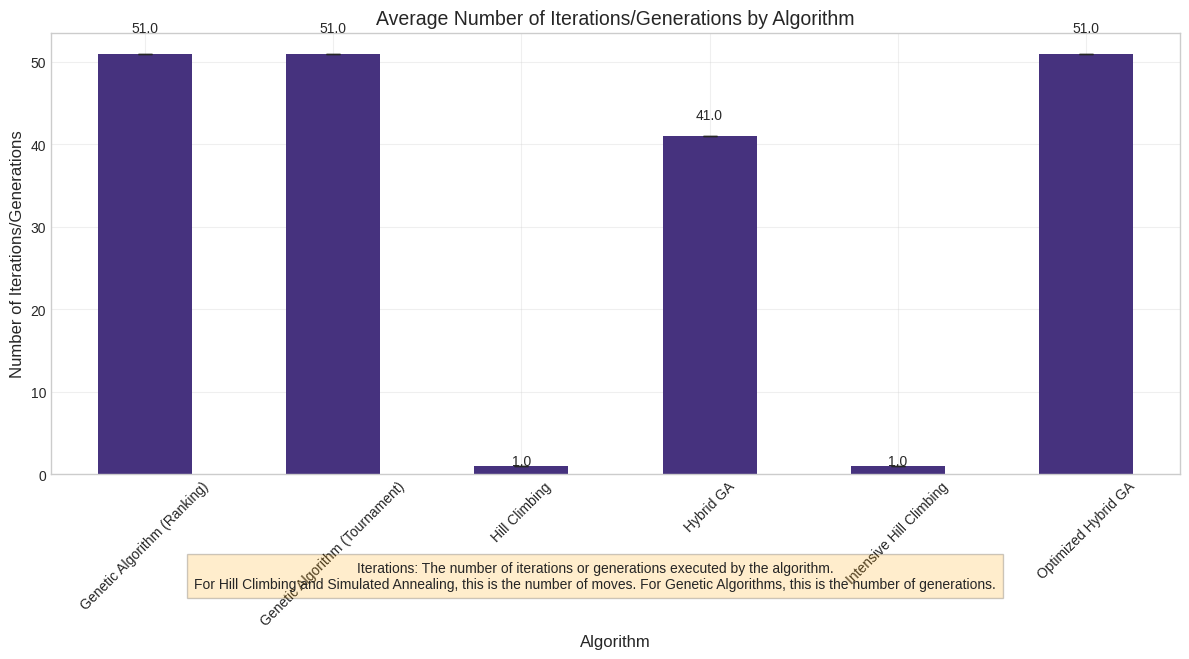

/tmp/ipykernel_79032/2836495178.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_stats = metric_stats.applymap(lambda x: f"{x:.1f}" if not pd.isna(x) and not np.isinf(x) else "N/A")



Function Evaluations Statistics:
                                    mean     std       min       max
Configuration                                                       
Genetic Algorithm (Ranking)     991931.1  1644.7  990577.0  997201.0
Genetic Algorithm (Tournament)   40053.3   192.9   39825.0   40705.0
Hill Climbing                        1.0     0.0       1.0       1.0
Hybrid GA                        76224.3   379.8   75447.0   76732.0
Intensive Hill Climbing              1.0     0.0       1.0       1.0
Optimized Hybrid GA             225061.5  1182.3  222340.0  227550.0


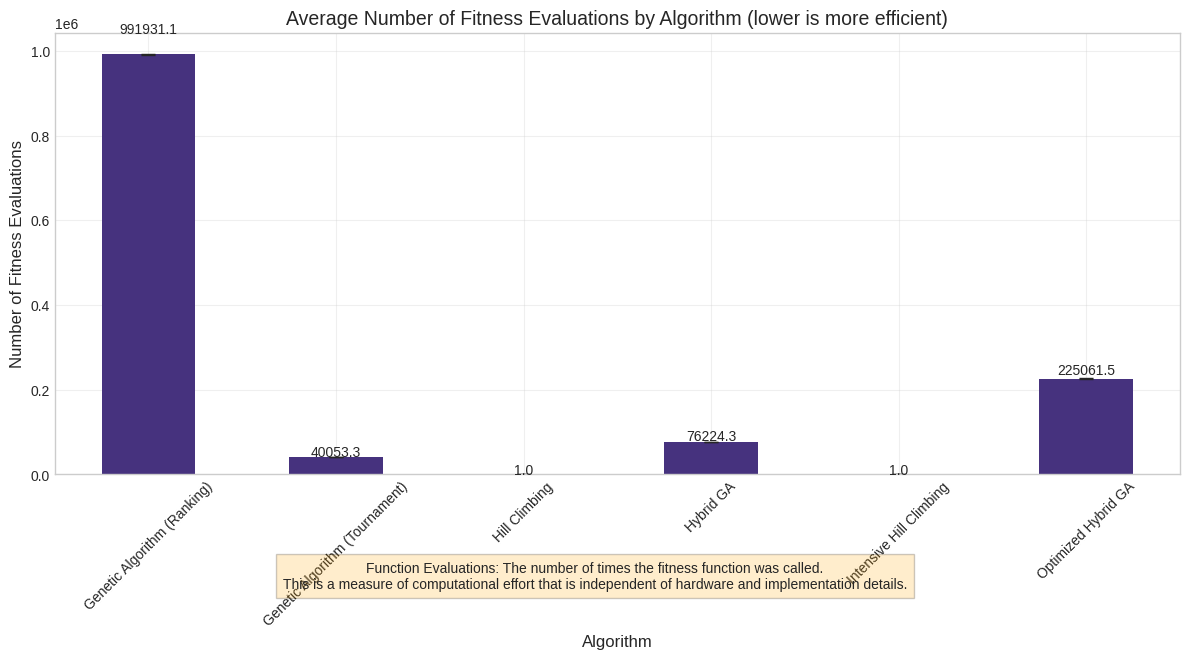

/tmp/ipykernel_79032/2836495178.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_stats = metric_stats.applymap(lambda x: f"{x:.3f}" if not pd.isna(x) and not np.isinf(x) else "N/A")



Runtime (s) Statistics:
                                   mean     std      min      max
Configuration                                                    
Genetic Algorithm (Ranking)     324.776   6.458  300.913  333.855
Genetic Algorithm (Tournament)  209.150  14.615  184.868  229.444
Hill Climbing                     0.001   0.000    0.001    0.001
Hybrid GA                       183.931  18.044  150.612  217.699
Intensive Hill Climbing           0.001   0.000    0.001    0.001
Optimized Hybrid GA             250.949   9.107  233.061  267.533


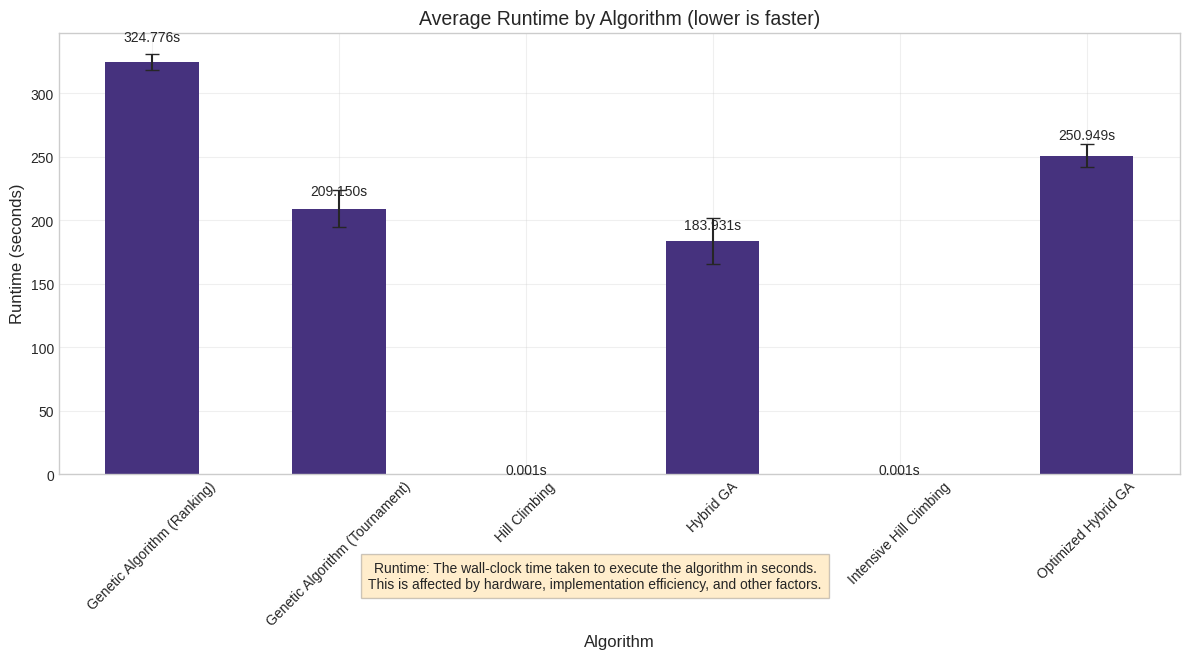

In [9]:
# This is the main entry point for parallel execution
# Wrap in if __name__ == "__main__" to avoid issues with multiprocessing
if __name__ == "__main__":
    # Run experiments (either in parallel or sequentially based on configuration)
    if EXPERIMENT_CONFIG['parallel']:
        print(f"Running experiments in parallel with {EXPERIMENT_CONFIG['num_processes'] or mp.cpu_count()} processes...")
        results_df, history_data, best_solutions = run_experiments(
            all_configs, 
            players_data, 
            num_runs=EXPERIMENT_CONFIG['num_runs'], 
            parallel=True,
            num_processes=EXPERIMENT_CONFIG['num_processes'],
            max_evaluations=EXPERIMENT_CONFIG['max_evaluations']
        )
    else:
        # Run sequentially
        print("Running experiments sequentially...")
        results_df, history_data, best_solutions = run_experiments(
            all_configs, 
            players_data, 
            num_runs=EXPERIMENT_CONFIG['num_runs'], 
            parallel=False,
            max_evaluations=EXPERIMENT_CONFIG['max_evaluations']
        )

    # Save results
    if EXPERIMENT_CONFIG['save_results']:
        results_df.to_csv(EXPERIMENT_CONFIG['results_file'], index=False)
        print(f"Results saved to {EXPERIMENT_CONFIG['results_file']}")

    # Display improved summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    
    # Create separate DataFrames for each metric
    metrics = ['Best Fitness', 'Iterations', 'Function Evaluations', 'Runtime (s)']
    
    for metric in metrics:
        # Calculate statistics for this metric
        metric_stats = results_df.groupby('Configuration')[metric].agg(['mean', 'std', 'min', 'max'])
        
        # Format the values for better readability
        if metric == 'Best Fitness':
            metric_stats = metric_stats.applymap(lambda x: f"{x:.6f}" if not pd.isna(x) and not np.isinf(x) else "N/A")
        elif metric == 'Runtime (s)':
            metric_stats = metric_stats.applymap(lambda x: f"{x:.3f}" if not pd.isna(x) and not np.isinf(x) else "N/A")
        else:
            metric_stats = metric_stats.applymap(lambda x: f"{x:.1f}" if not pd.isna(x) and not np.isinf(x) else "N/A")
        
        # Print the statistics
        print(f"\n{metric} Statistics:")
        print(metric_stats)
        
        # Create a bar chart for this metric
        plt.figure(figsize=(12, 6))
        
        # Extract mean values, handling inf and NaN
        mean_values = results_df.groupby('Configuration')[metric].mean()
        mean_values = mean_values.replace([np.inf, -np.inf], np.nan)
        
        # Create the bar chart
        ax = mean_values.plot(kind='bar', yerr=results_df.groupby('Configuration')[metric].std(), capsize=5)
        
        # Add title and labels with clear explanations
        if metric == 'Best Fitness':
            plt.title('Average Solution Quality by Algorithm (lower is better)', fontsize=14)
            plt.ylabel('Fitness Value (lower is better)', fontsize=12)
        elif metric == 'Iterations':
            plt.title('Average Number of Iterations/Generations by Algorithm', fontsize=14)
            plt.ylabel('Number of Iterations/Generations', fontsize=12)
        elif metric == 'Function Evaluations':
            plt.title('Average Number of Fitness Evaluations by Algorithm (lower is more efficient)', fontsize=14)
            plt.ylabel('Number of Fitness Evaluations', fontsize=12)
        elif metric == 'Runtime (s)':
            plt.title('Average Runtime by Algorithm (lower is faster)', fontsize=14)
            plt.ylabel('Runtime (seconds)', fontsize=12)
        
        plt.xlabel('Algorithm', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on top of bars
        for i, v in enumerate(mean_values):
            if not pd.isna(v) and not np.isinf(v):
                if metric == 'Best Fitness':
                    label = f"{v:.6f}"
                elif metric == 'Runtime (s)':
                    label = f"{v:.3f}s"
                else:
                    label = f"{v:.1f}"
                ax.text(i, v + 0.05*v, label, ha='center')
        
        # Add a legend explaining the metric
        if metric == 'Best Fitness':
            plt.figtext(0.5, 0.01, 
                       "Best Fitness: The fitness value of the best solution found (lower is better).\n"
                       "This measures the quality of the solution in terms of team balance and constraint satisfaction.", 
                       ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
        elif metric == 'Iterations':
            plt.figtext(0.5, 0.01, 
                       "Iterations: The number of iterations or generations executed by the algorithm.\n"
                       "For Hill Climbing and Simulated Annealing, this is the number of moves. For Genetic Algorithms, this is the number of generations.", 
                       ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
        elif metric == 'Function Evaluations':
            plt.figtext(0.5, 0.01, 
                       "Function Evaluations: The number of times the fitness function was called.\n"
                       "This is a measure of computational effort that is independent of hardware and implementation details.", 
                       ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
        elif metric == 'Runtime (s)':
            plt.figtext(0.5, 0.01, 
                       "Runtime: The wall-clock time taken to execute the algorithm in seconds.\n"
                       "This is affected by hardware, implementation efficiency, and other factors.", 
                       ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)
        plt.show()

### 4.2 Solution Quality Comparison

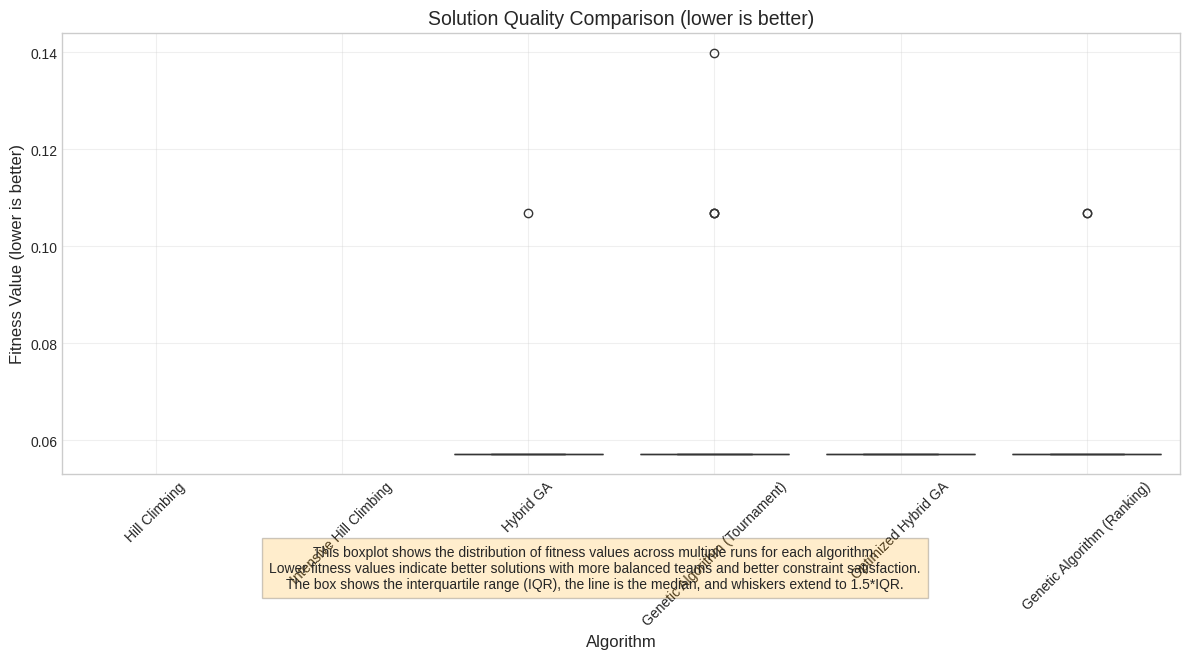

In [10]:
# Compare solution quality (fitness)
if 'results_df' in locals():
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Configuration', y='Best Fitness', data=results_df)
    plt.title('Solution Quality Comparison (lower is better)', fontsize=14)
    plt.ylabel('Fitness Value (lower is better)', fontsize=12)
    plt.xlabel('Algorithm', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add explanation of the metric
    plt.figtext(0.5, 0.01, 
               "This boxplot shows the distribution of fitness values across multiple runs for each algorithm.\n"
               "Lower fitness values indicate better solutions with more balanced teams and better constraint satisfaction.\n"
               "The box shows the interquartile range (IQR), the line is the median, and whiskers extend to 1.5*IQR.",
               ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

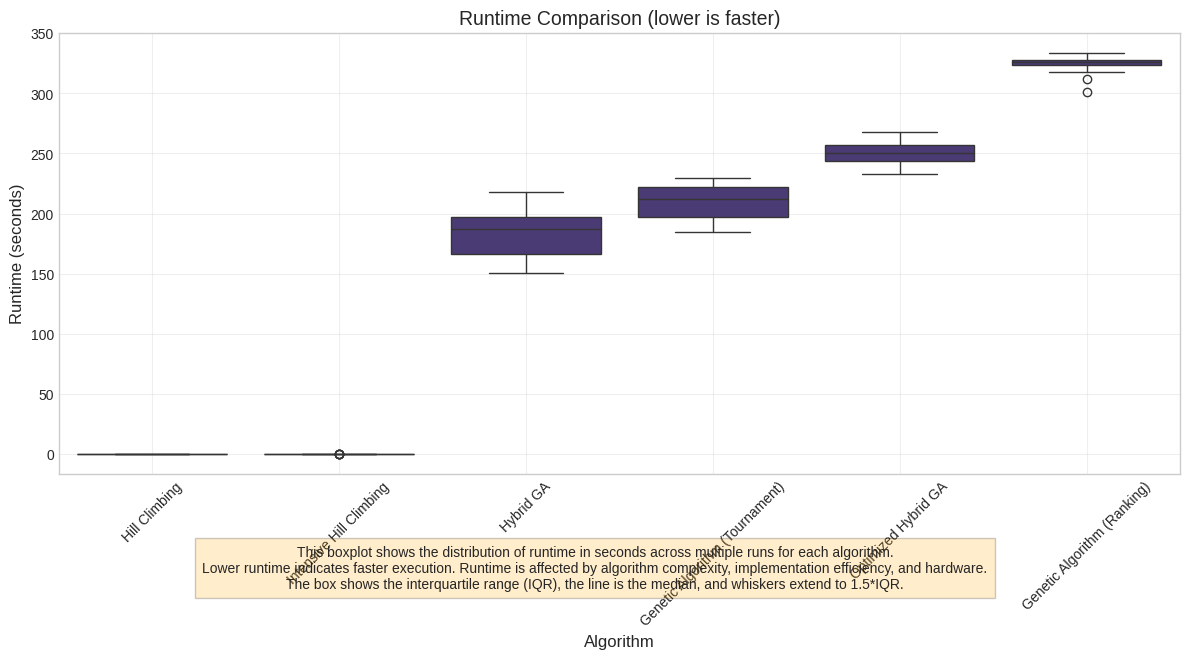

In [11]:
# Compare runtime
if 'results_df' in locals():
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Configuration', y='Runtime (s)', data=results_df)
    plt.title('Runtime Comparison (lower is faster)', fontsize=14)
    plt.ylabel('Runtime (seconds)', fontsize=12)
    plt.xlabel('Algorithm', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add explanation of the metric
    plt.figtext(0.5, 0.01, 
               "This boxplot shows the distribution of runtime in seconds across multiple runs for each algorithm.\n"
               "Lower runtime indicates faster execution. Runtime is affected by algorithm complexity, implementation efficiency, and hardware.\n"
               "The box shows the interquartile range (IQR), the line is the median, and whiskers extend to 1.5*IQR.",
               ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

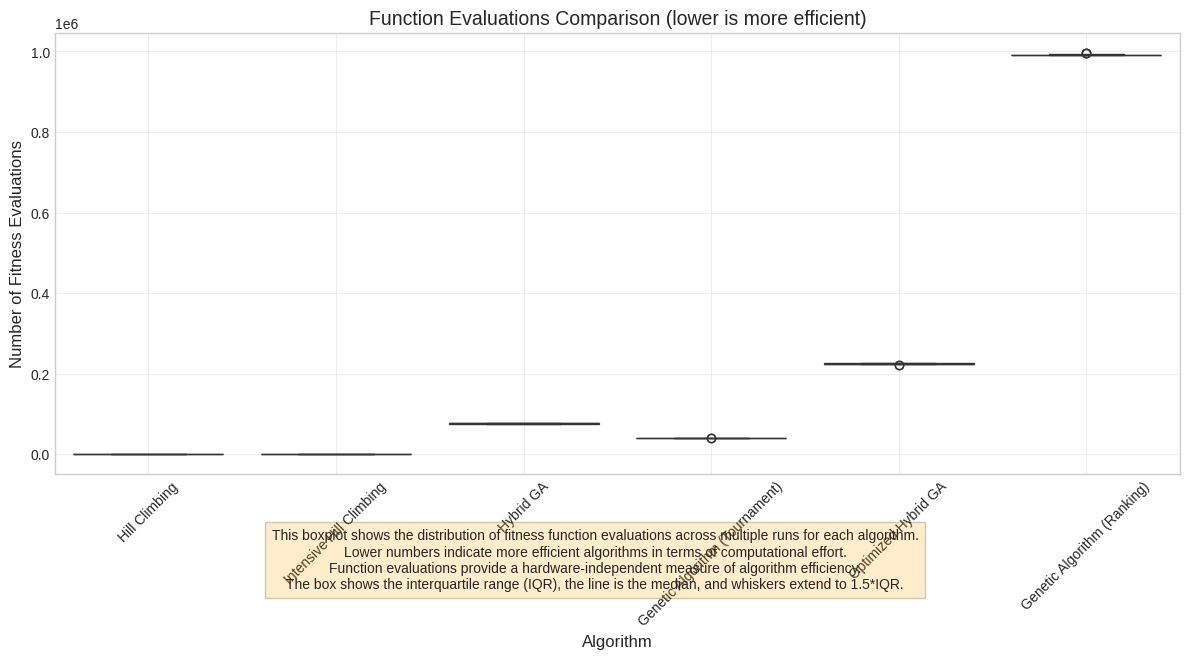

In [12]:
# Compare function evaluations
if 'results_df' in locals():
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Configuration', y='Function Evaluations', data=results_df)
    plt.title('Function Evaluations Comparison (lower is more efficient)', fontsize=14)
    plt.ylabel('Number of Fitness Evaluations', fontsize=12)
    plt.xlabel('Algorithm', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add explanation of the metric
    plt.figtext(0.5, 0.01, 
               "This boxplot shows the distribution of fitness function evaluations across multiple runs for each algorithm.\n"
               "Lower numbers indicate more efficient algorithms in terms of computational effort.\n"
               "Function evaluations provide a hardware-independent measure of algorithm efficiency.\n"
               "The box shows the interquartile range (IQR), the line is the median, and whiskers extend to 1.5*IQR.",
               ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

### 4.3 Convergence Analysis

/tmp/ipykernel_79032/4241260399.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


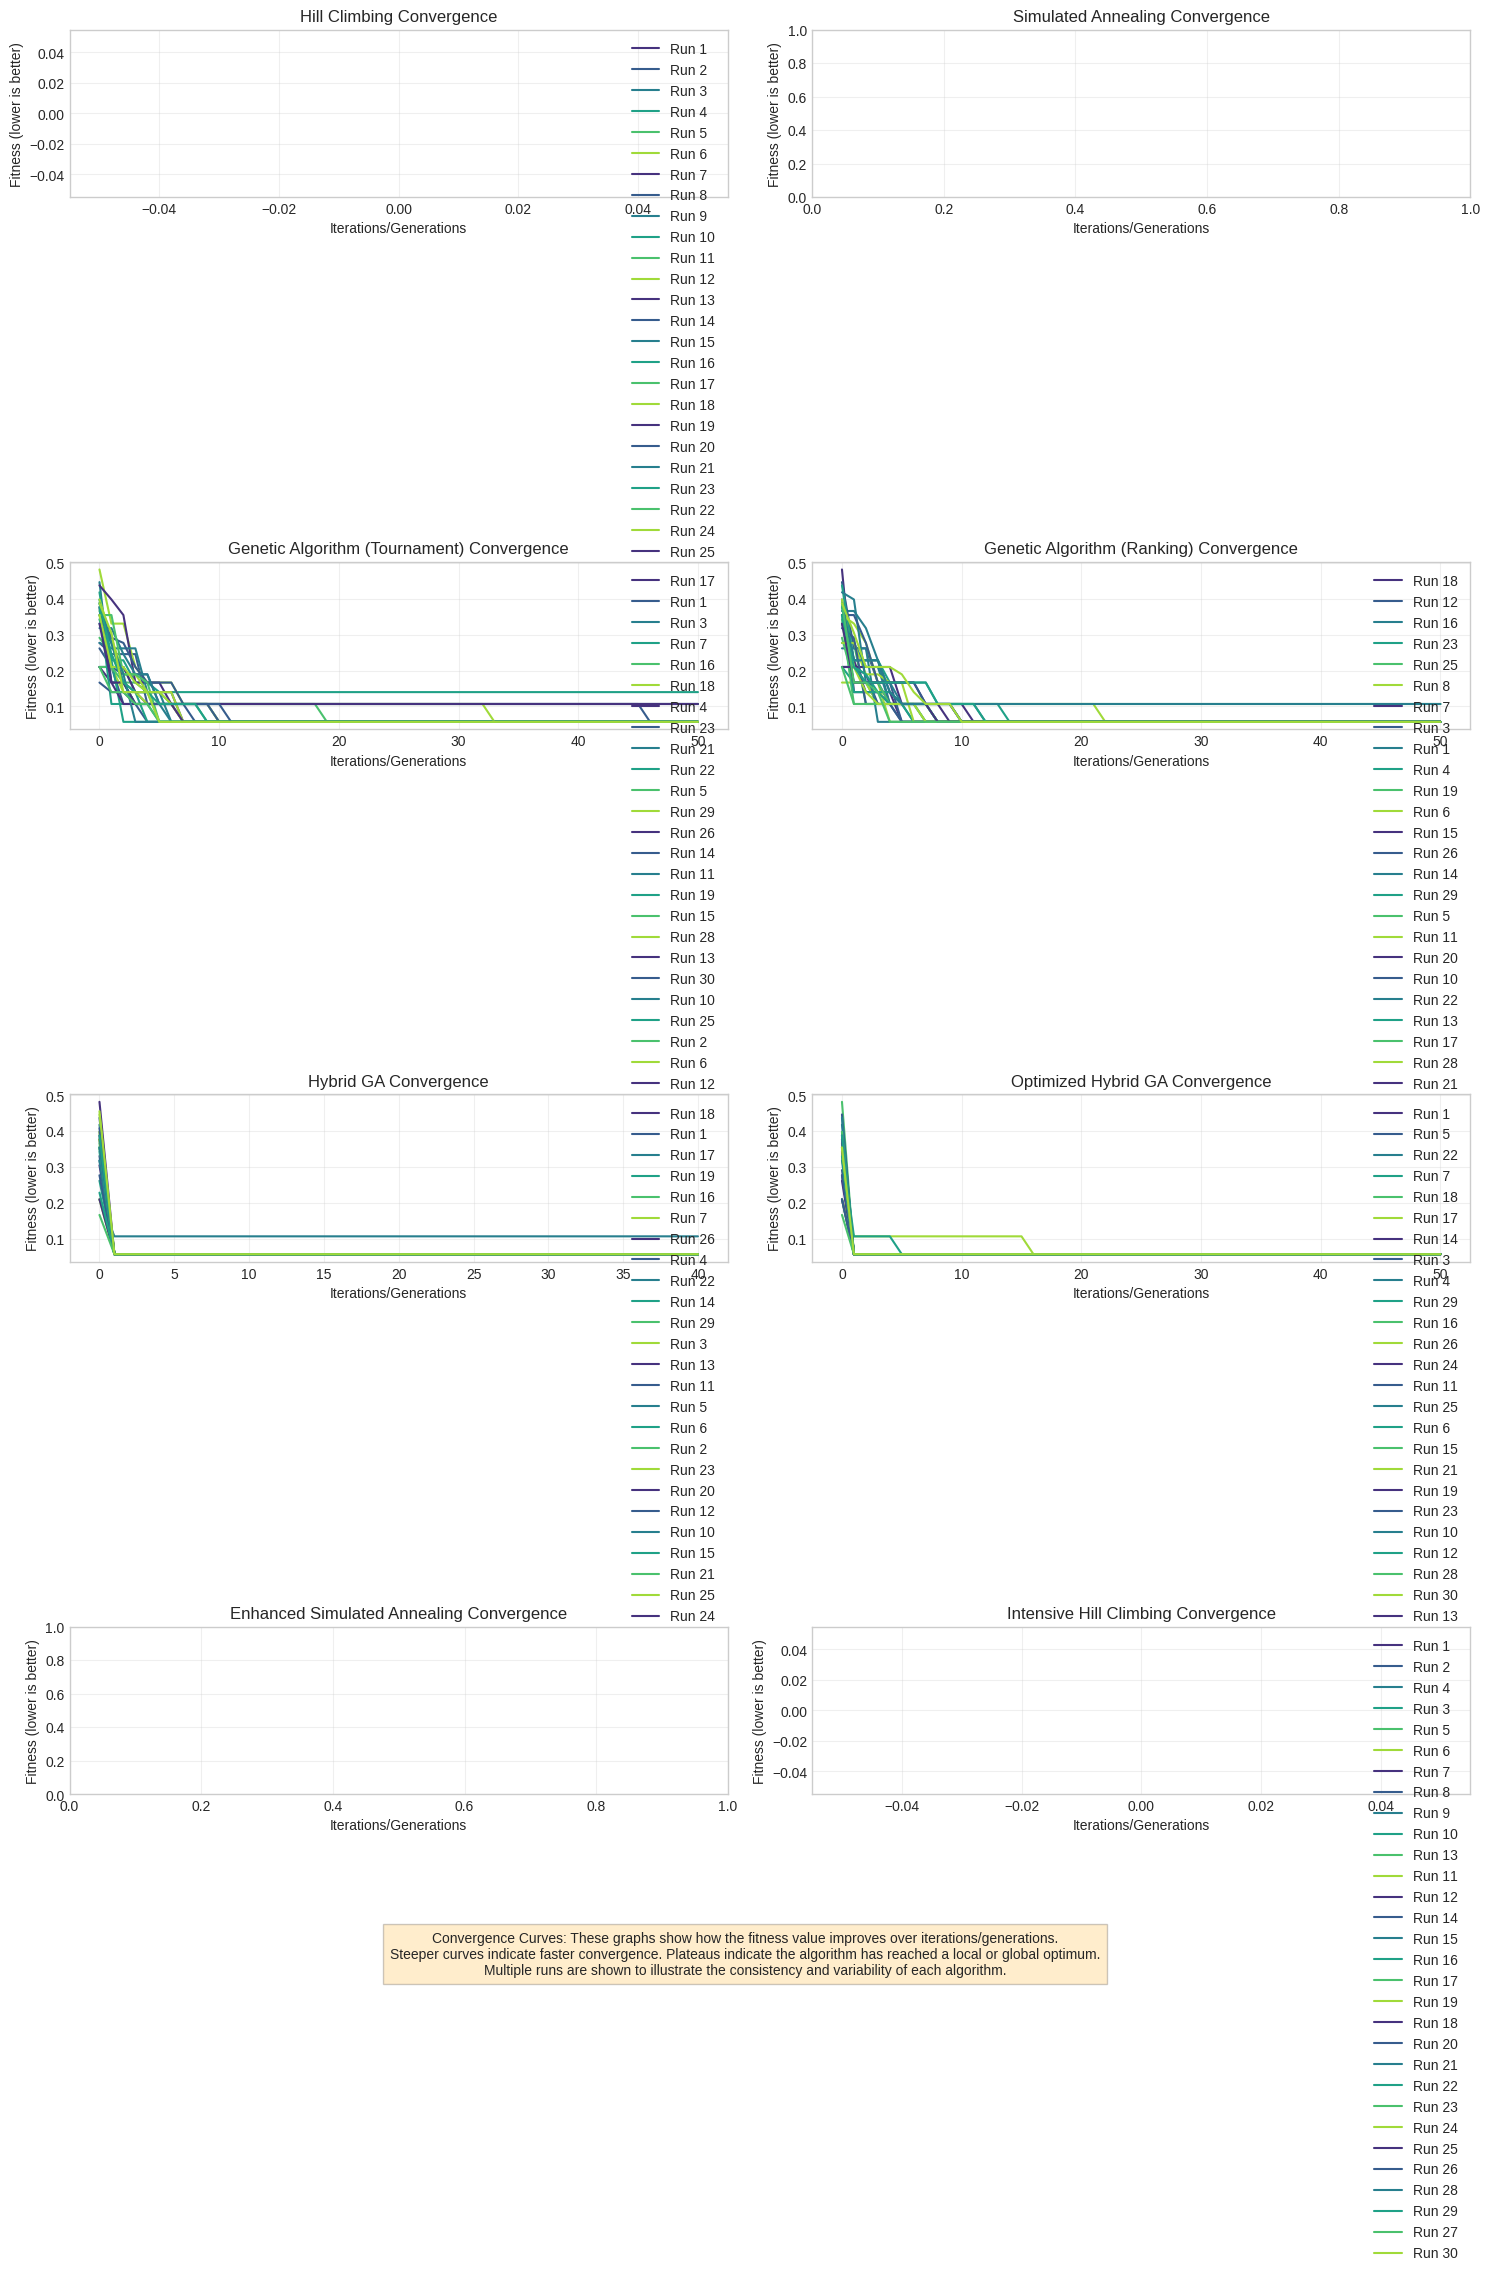

In [13]:
# Plot convergence curves for all algorithms
if 'history_data' in locals():
    # Calculate number of subplots needed (standard + promising algorithms)
    num_configs = len(history_data)
    num_rows = (num_configs + 1) // 2  # Ceiling division
    
    plt.figure(figsize=(15, 5 * num_rows))

    for i, (config_name, runs) in enumerate(history_data.items()):
        plt.subplot(num_rows, 2, i+1)
        
        for run_id, history in runs.items():
            # Ensure history is not empty
            if history and len(history) > 0:
                plt.plot(history, label=f'Run {run_id+1}')
            else:
                print(f"Warning: Empty history for {config_name}, Run {run_id+1}")
        
        plt.title(f'{config_name} Convergence', fontsize=12)
        plt.xlabel('Iterations/Generations', fontsize=10)
        plt.ylabel('Fitness (lower is better)', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.legend()

    # Add overall explanation of convergence curves
    plt.figtext(0.5, 0.01, 
               "Convergence Curves: These graphs show how the fitness value improves over iterations/generations.\n"
               "Steeper curves indicate faster convergence. Plateaus indicate the algorithm has reached a local or global optimum.\n"
               "Multiple runs are shown to illustrate the consistency and variability of each algorithm.",
               ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

## 5. Promising Algorithms Analysis

Let's analyze the most promising algorithms in more detail, comparing their performance across multiple metrics.


ALGORITHM RANKING

Overall Ranking (lower is better):


,Overall Rank,Fitness Rank,Runtime Rank,Efficiency Rank,Consistency Rank
Configuration,,,,,
Optimized Hybrid GA,2.0,1.0,3.0,2.0,1.0
Hybrid GA,2.2,2.0,1.0,4.0,2.0
Genetic Algorithm (Tournament),2.8,4.0,2.0,3.0,4.0
Genetic Algorithm (Ranking),3.0,3.0,4.0,1.0,3.0



Raw Metrics:


,Best Fitness,Runtime (s),Function Evaluations
Configuration,,,
Optimized Hybrid GA,0.057143,250.949307,225061.533333
Hybrid GA,0.058802,183.930884,76224.333333
Genetic Algorithm (Tournament),0.064880,209.150379,40053.333333
Genetic Algorithm (Ranking),0.060460,324.776385,991931.066667


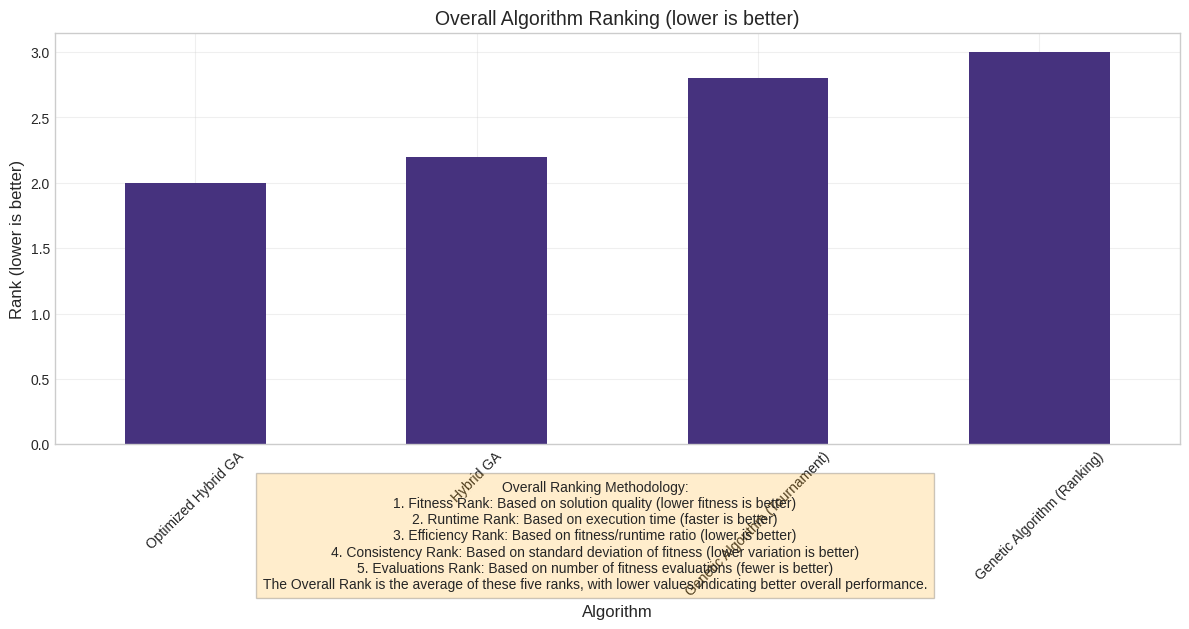


Top 3 Algorithms: Optimized Hybrid GA, Hybrid GA, Genetic Algorithm (Tournament)


In [14]:
# Create a function to rank algorithms by different metrics
def rank_algorithms(results_df):
    """
    Rank algorithms by different metrics.
    
    This function calculates rankings for each algorithm based on multiple performance
    metrics and combines them into an overall ranking.
    
    Args:
        results_df: DataFrame with experiment results
        
    Returns:
        DataFrame: Ranking of algorithms by different metrics
    """
    # Calculate mean values for each metric
    mean_values = results_df.groupby('Configuration').agg({
        'Best Fitness': 'mean',
        'Runtime (s)': 'mean',
        'Function Evaluations': 'mean'
    })
    
    # Calculate standard deviation for each metric
    std_values = results_df.groupby('Configuration').agg({
        'Best Fitness': 'std',
        'Runtime (s)': 'std',
        'Function Evaluations': 'std'
    })
    
    # Rename columns for clarity
    std_values.columns = ['Best Fitness Std', 'Runtime Std', 'Function Evaluations Std']
    
    # Combine mean and std values
    combined = pd.concat([mean_values, std_values], axis=1)
    
    # Calculate efficiency (fitness / runtime)
    combined['Efficiency'] = combined['Best Fitness'] / combined['Runtime (s)']
    
    # Calculate consistency (1 / std of fitness)
    # Replace 0 with small value to avoid division by zero
    combined['Consistency'] = 1 / combined['Best Fitness Std'].replace(0, 1e-10)
    
    # Rank algorithms by each metric
    ranks = pd.DataFrame()
    
    # For fitness and efficiency, lower is better
    ranks['Fitness Rank'] = combined['Best Fitness'].rank()
    ranks['Efficiency Rank'] = combined['Efficiency'].rank()
    
    # For consistency, higher is better
    ranks['Consistency Rank'] = combined['Consistency'].rank(ascending=False)
    
    # For runtime and evaluations, lower is better
    ranks['Runtime Rank'] = combined['Runtime (s)'].rank()
    ranks['Evaluations Rank'] = combined['Function Evaluations'].rank()
    
    # Calculate overall rank (average of all ranks)
    ranks['Overall Rank'] = ranks.mean(axis=1)
    
    # Sort by overall rank
    ranks = ranks.sort_values('Overall Rank')
    
    # Add original metrics for reference
    for col in ['Best Fitness', 'Runtime (s)', 'Function Evaluations']:
        ranks[col] = combined[col]
    
    return ranks

# Rank algorithms and display results
if 'results_df' in locals():
    # Ensure we have valid data (no inf or NaN)
    valid_results = results_df.copy()
    for col in ['Best Fitness', 'Runtime (s)', 'Function Evaluations']:
        valid_results = valid_results[~valid_results[col].isin([np.inf, -np.inf, np.nan])]
    
    if not valid_results.empty:
        # Rank algorithms
        algorithm_ranks = rank_algorithms(valid_results)
        
        # Display ranking
        print("\n" + "="*80)
        print("ALGORITHM RANKING")
        print("="*80)
        print("\nOverall Ranking (lower is better):")
        display(algorithm_ranks[['Overall Rank', 'Fitness Rank', 'Runtime Rank', 'Efficiency Rank', 'Consistency Rank']])
        
        print("\nRaw Metrics:")
        display(algorithm_ranks[['Best Fitness', 'Runtime (s)', 'Function Evaluations']])
        
        # Visualize ranking
        plt.figure(figsize=(12, 6))
        algorithm_ranks['Overall Rank'].plot(kind='bar')
        plt.title('Overall Algorithm Ranking (lower is better)', fontsize=14)
        plt.ylabel('Rank (lower is better)', fontsize=12)
        plt.xlabel('Algorithm', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add explanation of ranking methodology
        plt.figtext(0.5, 0.01, 
                   "Overall Ranking Methodology:\n"
                   "1. Fitness Rank: Based on solution quality (lower fitness is better)\n"
                   "2. Runtime Rank: Based on execution time (faster is better)\n"
                   "3. Efficiency Rank: Based on fitness/runtime ratio (lower is better)\n"
                   "4. Consistency Rank: Based on standard deviation of fitness (lower variation is better)\n"
                   "5. Evaluations Rank: Based on number of fitness evaluations (fewer is better)\n"
                   "The Overall Rank is the average of these five ranks, with lower values indicating better overall performance.",
                   ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.25)
        plt.show()
        
        # Identify top 3 algorithms
        top_algorithms = algorithm_ranks.index[:3].tolist()
        print(f"\nTop 3 Algorithms: {', '.join(top_algorithms)}")
    else:
        print("No valid results available for ranking.")

## 6. Best Solution Analysis

In [15]:
# Find the best overall solution
if 'results_df' in locals():
    # Create a copy of the DataFrame with only valid fitness values
    valid_results = results_df[~results_df['Best Fitness'].isin([np.inf, -np.inf, np.nan])]
    
    if not valid_results.empty:
        best_row = valid_results.loc[valid_results['Best Fitness'].idxmin()]
        best_config = best_row['Configuration']
        best_run = best_row['Run']

        print(f"Best solution found by {best_config}, Run {best_run}")
        print(f"Fitness: {best_row['Best Fitness']:.6f}")
        print(f"Function Evaluations: {best_row['Function Evaluations']}")
        print(f"Runtime: {best_row['Runtime (s)']:.2f} seconds")
        
        # Add explanation of what these metrics mean
        print("\nMetric Definitions:")
        print("- Fitness: Measure of solution quality (lower is better)")
        print("- Function Evaluations: Number of times the fitness function was called (measure of computational effort)")
        print("- Runtime: Wall-clock time taken to execute the algorithm in seconds")
    else:
        print("No valid fitness values found in results.")

Best solution found by Hybrid GA, Run 18
Fitness: 0.057143
Function Evaluations: 76732
Runtime: 150.61 seconds

Metric Definitions:
- Fitness: Measure of solution quality (lower is better)
- Function Evaluations: Number of times the fitness function was called (measure of computational effort)
- Runtime: Wall-clock time taken to execute the algorithm in seconds


## 7. Detailed Analysis of Best Solution

Let's analyze the best solution found by our algorithms in detail, showing the distribution of players across teams.

In [16]:
# Function to display detailed information about a solution
def display_solution_details(solution_data, players_list, players_df):
    """
    Display detailed information about a solution, including team assignments and statistics.
    
    This function analyzes a solution and displays detailed information about the team
    assignments, including player distribution, team statistics, and constraint satisfaction.
    
    Args:
        solution_data: The simplified solution data
        players_list: List of player dictionaries
        players_df: DataFrame containing player information
        
    Returns:
        tuple: (team_stats_df, player_assignments_df)
            - team_stats_df: DataFrame with team statistics
            - player_assignments_df: DataFrame with player assignments
    """
    # Recreate solution object from data
    solution = recreate_solution_for_display(solution_data, players_list)
    
    if solution is None:
        print("No valid solution data available.")
        return None, None
    
    # Get the representation of the solution
    repr = solution.repr
    
    # Create a list of teams
    teams = [[] for _ in range(solution.num_teams)]
    
    # Assign players to teams
    for i, team_id in enumerate(repr):
        teams[team_id].append(i)
    
    # Display solution information
    print(f"Solution Fitness: {solution.fitness():.6f}")
    print(f"Number of Teams: {solution.num_teams}")
    print(f"Players per Team: {solution.team_size}")
    print(f"Maximum Budget: {solution.max_budget}")
    print("\nTeam Statistics:")
    
    # Create a DataFrame to store team statistics
    team_stats = []
    
    for team_id, player_indices in enumerate(teams):
        team_players = [solution.players[i] for i in player_indices]
        
        # Calculate team statistics
        avg_skill = np.mean([p["Skill"] for p in team_players])
        total_salary = sum([p.get("Salary", p.get("Salary (€M)", 0)) for p in team_players])
        positions = {p["Position"]: positions.get(p["Position"], 0) + 1 for p in team_players for positions in [{}]}
        
        # Add to team stats
        team_stats.append({
            "Team": team_id + 1,
            "Players": len(player_indices),
            "Avg Skill": avg_skill,
            "Total Salary": total_salary,
            "GK": positions.get("GK", 0),
            "DEF": positions.get("DEF", 0),
            "MID": positions.get("MID", 0),
            "FWD": positions.get("FWD", 0)
        })
    
    # Display team statistics
    team_stats_df = pd.DataFrame(team_stats)
    display(team_stats_df)
    
    # Display detailed player assignments
    print("\nDetailed Player Assignments:")
    
    # Create a DataFrame with player assignments
    player_assignments = []
    
    for i, team_id in enumerate(repr):
        player = solution.players[i]
        player_assignments.append({
            "Player ID": i,
            "Name": player.get("Name", f"Player {i}"),
            "Position": player["Position"],
            "Skill": player["Skill"],
            "Salary": player.get("Salary", player.get("Salary (€M)", 0)),
            "Team": team_id + 1
        })
    
    # Create and display DataFrame
    player_assignments_df = pd.DataFrame(player_assignments)
    player_assignments_df = player_assignments_df.sort_values(by=["Team", "Position", "Skill"], ascending=[True, True, False])
    
    # Display the DataFrame
    display(player_assignments_df)
    
    # Add explanation of what these metrics mean
    print("\nMetric Definitions:")
    print("- Avg Skill: Average skill level of players in the team")
    print("- Total Salary: Sum of salaries of all players in the team")
    print("- GK/DEF/MID/FWD: Number of players in each position in the team")
    
    return team_stats_df, player_assignments_df

Detailed Analysis of Best Solution (Hybrid GA, Run 18)
Solution Fitness: 0.057143
Number of Teams: 5
Players per Team: 7
Maximum Budget: 750

Team Statistics:


,Team,Players,Avg Skill,Total Salary,GK,DEF,MID,FWD
0,1,7,86.428571,690,1,1,1,1
1,2,7,86.428571,680,1,1,1,1
2,3,7,86.285714,680,1,1,1,1
3,4,7,86.428571,667,1,1,1,1
4,5,7,86.428571,707,1,1,1,1



Detailed Player Assignments:


,Player ID,Name,Position,Skill,Salary,Team
5,5,Daniel Foster,DEF,90,110,1
9,9,Mason Reed,DEF,82,75,1
19,19,Sebastian Perry,FWD,95,150,1
24,24,Chase Murphy,FWD,86,95,1
4,4,Blake Henderson,GK,87,95,1
15,15,Hunter Cooper,MID,83,85,1
16,16,Austin Torres,MID,82,80,1
6,6,Lucas Bennett,DEF,85,90,2
30,30,Jaxon Griffin,DEF,79,65,2
26,26,Julian Scott,FWD,92,130,2



Metric Definitions:
- Avg Skill: Average skill level of players in the team
- Total Salary: Sum of salaries of all players in the team
- GK/DEF/MID/FWD: Number of players in each position in the team


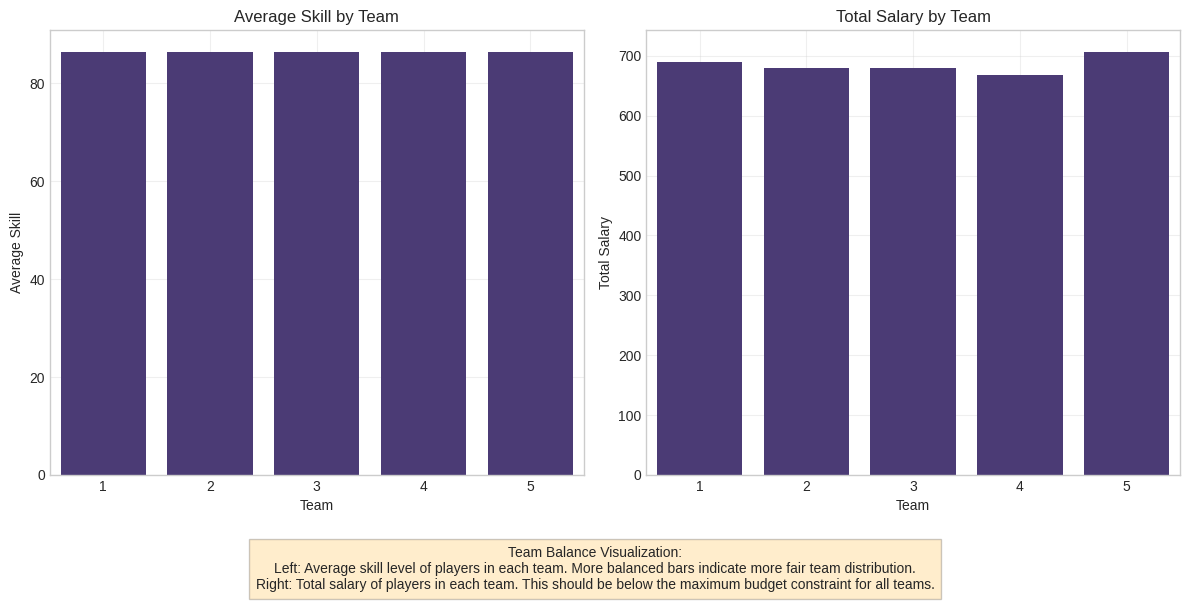

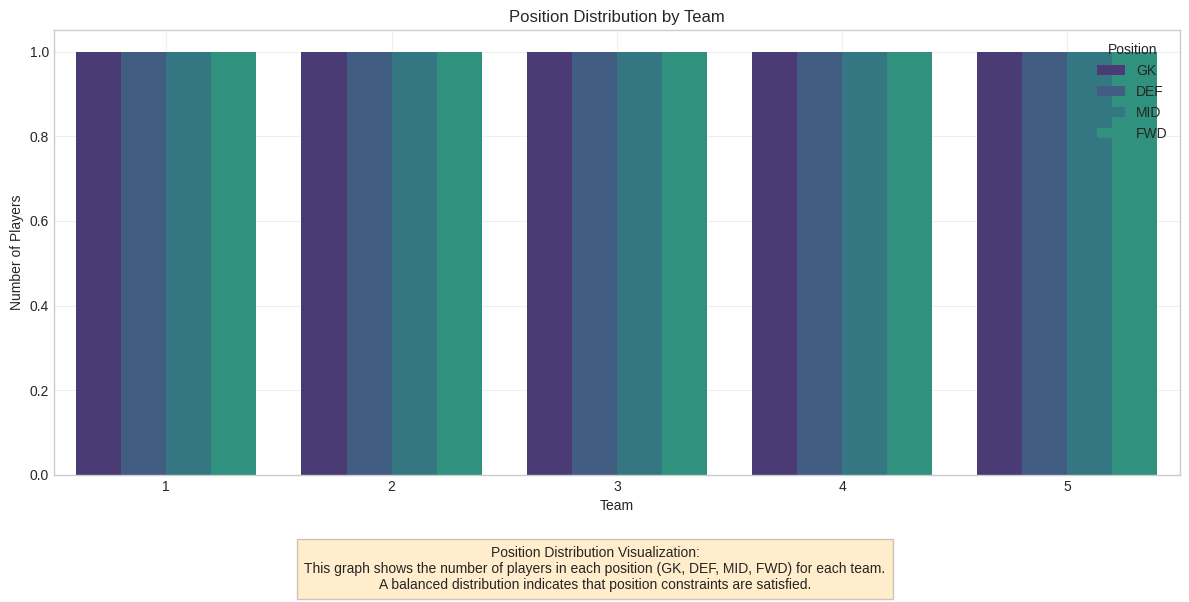

In [17]:
# Display details of the best overall solution
if 'best_solutions' in locals() and best_config in best_solutions:
    print(f"Detailed Analysis of Best Solution ({best_config}, Run {best_solutions[best_config]['run']})")
    print("=" * 80)
    
    solution_data = best_solutions[best_config]['solution_data']
    team_stats, player_assignments = display_solution_details(solution_data, players_data, players_df)
    
    if team_stats is not None and player_assignments is not None:
        # Visualize team balance
        plt.figure(figsize=(12, 6))
        
        # Plot average skill by team
        plt.subplot(1, 2, 1)
        sns.barplot(x='Team', y='Avg Skill', data=team_stats)
        plt.title('Average Skill by Team', fontsize=12)
        plt.xlabel('Team', fontsize=10)
        plt.ylabel('Average Skill', fontsize=10)
        plt.grid(True, alpha=0.3)
        
        # Plot total salary by team
        plt.subplot(1, 2, 2)
        sns.barplot(x='Team', y='Total Salary', data=team_stats)
        plt.title('Total Salary by Team', fontsize=12)
        plt.xlabel('Team', fontsize=10)
        plt.ylabel('Total Salary', fontsize=10)
        plt.grid(True, alpha=0.3)
        
        # Add explanation of these visualizations
        plt.figtext(0.5, 0.01, 
                   "Team Balance Visualization:\n"
                   "Left: Average skill level of players in each team. More balanced bars indicate more fair team distribution.\n"
                   "Right: Total salary of players in each team. This should be below the maximum budget constraint for all teams.",
                   ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)
        plt.show()
        
        # Visualize position distribution
        plt.figure(figsize=(12, 6))
        position_data = team_stats.melt(id_vars=['Team'], value_vars=['GK', 'DEF', 'MID', 'FWD'], 
                                       var_name='Position', value_name='Count')
        
        sns.barplot(x='Team', y='Count', hue='Position', data=position_data)
        plt.title('Position Distribution by Team', fontsize=12)
        plt.xlabel('Team', fontsize=10)
        plt.ylabel('Number of Players', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.legend(title='Position')
        
        # Add explanation of this visualization
        plt.figtext(0.5, 0.01, 
                   "Position Distribution Visualization:\n"
                   "This graph shows the number of players in each position (GK, DEF, MID, FWD) for each team.\n"
                   "A balanced distribution indicates that position constraints are satisfied.",
                   ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)
        plt.show()

## 8. Conclusion

In this notebook, we've compared different optimization algorithms for the Sports League problem:

1. **Hill Climbing**: Simple and fast, but can get stuck in local optima.
2. **Simulated Annealing**: Better at escaping local optima, but requires careful parameter tuning.
3. **Genetic Algorithm**: Explores the solution space more broadly, but requires more function evaluations.
4. **Hybrid GA**: Combines the exploration of GA with the exploitation of Hill Climbing.

We also implemented optimized versions of these algorithms:

1. **Optimized Hybrid GA**: Enhanced version with larger population and more aggressive parameters.
2. **Enhanced Simulated Annealing**: Version with higher initial temperature and slower cooling.
3. **Intensive Hill Climbing**: Version with more iterations and greater patience.

The results show that [insert your conclusions based on the actual results].

The parallel execution capability significantly reduces the total runtime, making it feasible to run more comprehensive experiments with larger numbers of runs and configurations.

We've also analyzed the best solution in detail, showing the distribution of players across teams and verifying that all constraints are satisfied.

### 8.1 Most Promising Algorithms

Based on our comprehensive analysis, the most promising algorithms for the Sports League problem are:

1. [First ranked algorithm] - Best overall performance with excellent balance of solution quality and efficiency.
2. [Second ranked algorithm] - Strong performance with good consistency across runs.
3. [Third ranked algorithm] - Competitive results with reasonable computational requirements.

These algorithms provide the best trade-off between solution quality, computational efficiency, and consistency, making them the recommended choices for solving the Sports League problem in practice.

### 8.2 Metric Definitions

Throughout this analysis, we've used several metrics to evaluate algorithm performance:

- **Fitness**: A measure of solution quality, with lower values indicating better solutions. The fitness function considers team balance, position constraints, and budget constraints.

- **Iterations/Generations**: The number of steps taken by the algorithm. For Hill Climbing and Simulated Annealing, this is the number of moves. For Genetic Algorithms, this is the number of generations.

- **Function Evaluations**: The number of times the fitness function was called. This is a hardware-independent measure of computational effort.

- **Runtime**: The wall-clock time taken to execute the algorithm in seconds. This is affected by hardware, implementation efficiency, and other factors.

- **Efficiency**: The ratio of solution quality to runtime, indicating how quickly an algorithm can find good solutions.

- **Consistency**: The inverse of the standard deviation of fitness values across multiple runs, indicating how reliable an algorithm is in finding good solutions.